In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

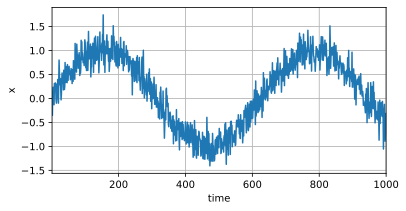

In [3]:
# 使用正弦函数和一些可加性噪声来生成序列数据，时间步为1，2，...., 1000
T = 1000  # 共产生1000个点
time = torch.arange(1, T+1, dtype=torch.float32)   # 1-1000
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

torch.Size([1000])

In [5]:
# 接下来，我们将这个序型的 列转换为模型的特征-标签（feature-label）时。
# 基于3个长度为996的序列，预测下一个序列。4阶马尔科夫模型
tau = 4
features = torch.zeros((T - tau, tau))  # [996, 4]
for i in range(tau):  # 赋值，996行4列
    features[:, i] = x[i: T - tau + i]  # (0, 996), (1, 997), (2, 998), (3, 999)
labels = x[tau:].reshape((-1, 1))  # [1, 996]
batch_size, n_train = 16, 600
# 只用前n_train 个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [18]:
for x, y in train_iter:
    print(x.shape, y.shape)
    break

torch.Size([16, 4]) torch.Size([16, 1])


In [6]:
# 在这里，我们使用一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失

In [10]:
# 初始化网络权重的参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net
# 平方损失。注意MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [12]:
# 训练模型
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch+1}',
              f'loss:{d2l.evaluate_loss(net, train_iter, loss):f}')
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1 loss:0.071888
epoch 2 loss:0.055817
epoch 3 loss:0.054163
epoch 4 loss:0.053721
epoch 5 loss:0.054616


In [9]:
# 预测
# 由于训练损失很小， 因此我们期望模型能有很好的工作效果。让我们看看这在实践中意味着什么。首先是检查模型预测下一个
# 时间步的能力，也就是单步预测

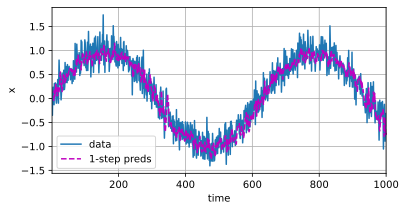

In [15]:
onestep_preds = net(features) # 预测了996个数据
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

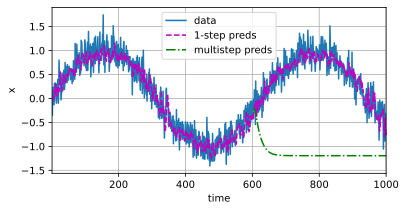

In [16]:
# 使用预测数据进行多步预测,就是说，使用我们预测出来的数据接着预测，结果会很烂。
multistep_preds = torch.zeros(T)
# [0, 604)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train+tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [15]:
# 基于k=1， 4， 16， 64 通过对整个序列预测的计算，看一些k步预测的困难

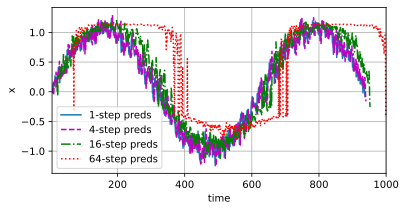

In [16]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))